In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Activation , Flatten , Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from glob import glob

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
categories=['Plain','Pothole']
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) # dictionary

print(label_dict)

{'Plain': 0, 'Pothole': 1}


In [3]:
train_path = "train"
test_path = "test"


image_size=224
training_data=[]
test_data=[]

def create_dataset(data_path,dataset):
    for category in categories:
        path=os.path.join(data_path,category)
        
        for img in os.listdir(path):
            try:
                
                img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                new_array=cv2.resize(img_array,(image_size,image_size))
                dataset.append([new_array,category])
            except:
                pass

create_dataset(train_path,training_data)
create_dataset(test_path,test_data)

In [4]:
# Shuffling the data
random.shuffle(training_data)
random.shuffle(test_data)

In [5]:
x_tr=[]
y_tr=[]

x_t=[]
y_t=[]

for features,labels in training_data:
    x_tr.append(features)
    y_tr.append(labels)

for features,labels in test_data:
    x_t.append(features)
    y_t.append(labels)

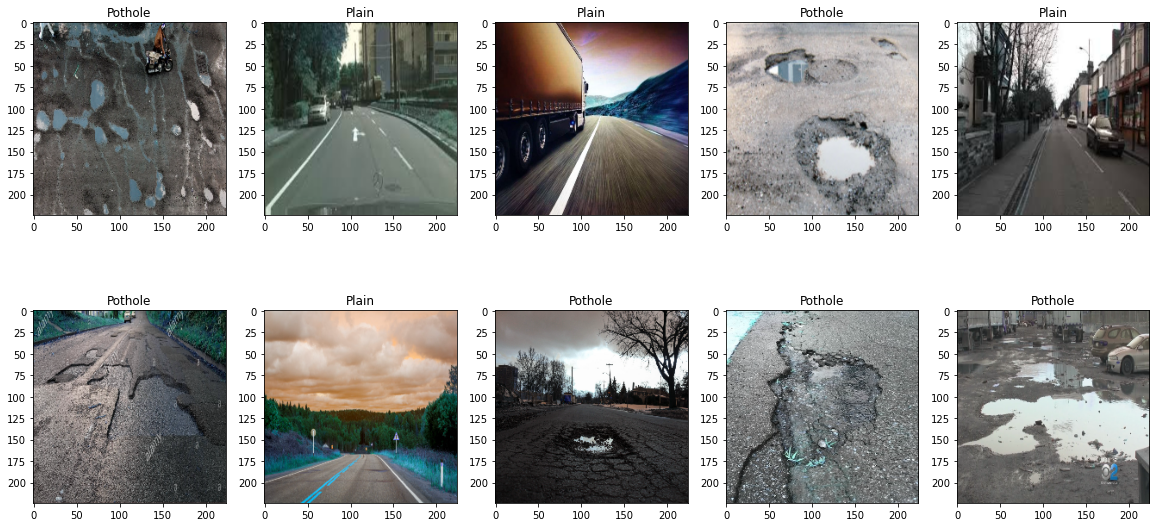

In [6]:
import random as rn
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(20,20)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(y_tr))
        ax[i,j].imshow(x_tr[l][:])
        ax[i,j].set_title(y_tr[l])
        ax[i,j].set_aspect('equal')

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
image_size=224
x_tr=np.array(x_tr)/255.0
x_train=np.array(x_tr).reshape(-1,image_size,image_size,3)
le = LabelEncoder()
y_tr  = le.fit_transform(y_tr)
tr_y  = to_categorical(y_tr)
y_train = []
for each in tr_y :
    y_train.append(each[1])
y_train=np.array(y_train)

x_t=np.array(x_t)/255.0
x_test=np.array(x_t).reshape(-1,image_size,image_size,3)
le = LabelEncoder()
y_t  = le.fit_transform(y_t)
test_y  = to_categorical(y_t)
y_test = []
for each in test_y :
    y_test.append(each[1])
y_test=np.array(y_test)

In [8]:
# Create a CNN Sequential Model
model_cnn = Sequential()

model_cnn.add(Conv2D(128, (5,5), padding='same', activation = 'relu', input_shape=(224,224,3)))
model_cnn.add(MaxPooling2D((2,2)))

model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model_cnn.add(MaxPooling2D((2, 2)))


model_cnn.add(Flatten())

model_cnn.add(Dropout(0.2))

model_cnn.add(Dense(256, activation='relu'))

model_cnn.add(Dense(1, activation='sigmoid'))

#Model configuration for training purpose
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
print(model_cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       2

In [ ]:
# simple early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc = ModelCheckpoint('best_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = model_cnn.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30,batch_size = 32, callbacks=[es, mc])

Train on 949 samples, validate on 239 samples
Epoch 1/30
928/949 [============================>.] - ETA: 17s - loss: 0.7306 - accuracy: 0.4957
Epoch 00001: val_accuracy improved from -inf to 0.50209, saving model to best_cnn.h5
949/949 [==============================] - 872s 919ms/sample - loss: 0.7287 - accuracy: 0.4995 - val_loss: 0.6949 - val_accuracy: 0.5021
Epoch 2/30
928/949 [============================>.] - ETA: 16s - loss: 0.6584 - accuracy: 0.6078
Epoch 00002: val_accuracy improved from 0.50209 to 0.85774, saving model to best_cnn.h5
949/949 [==============================] - 826s 870ms/sample - loss: 0.6585 - accuracy: 0.6091 - val_loss: 0.4152 - val_accuracy: 0.8577
Epoch 3/30
160/949 [====>.........................] - ETA: 10:31 - loss: 0.5403 - accuracy: 0.7312

In [24]:
model_saved = tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_cnn.h5")

In [12]:


def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

C:\Users\gayat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
C:\Users\gayat\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


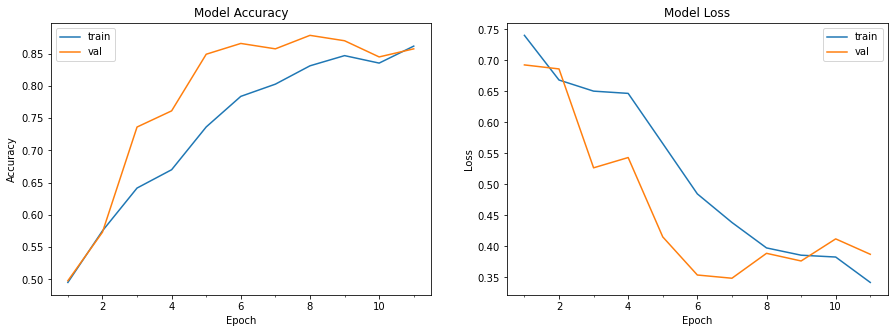

In [13]:
plot_model_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


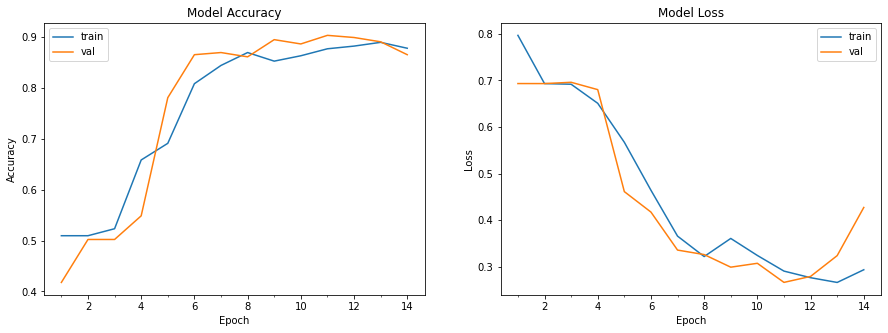

In [25]:
plot_model_history(history)

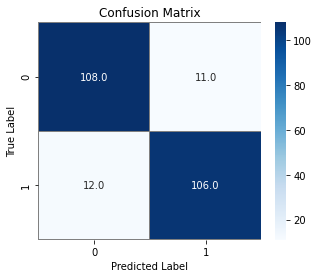

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_pred):
  # compute the confusion matrix
  confusion_mtx = confusion_matrix(y_test, y_pred) 
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(5, 4))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

y_pred_cnn =  model_saved.predict_classes(x_test)

plot_confusion_matrix(y_pred_cnn)

In [28]:
print(classification_report(y_test,y_pred_cnn))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       119
         1.0       0.91      0.90      0.90       118

    accuracy                           0.90       237
   macro avg       0.90      0.90      0.90       237
weighted avg       0.90      0.90      0.90       237



CNN with Data Augmentation

In [16]:
# horizontal flips and rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

AttributeError: module 'tensorflow.keras.layers.experimental.preprocessing' has no attribute 'RandomFlip'

In [ ]:
# Create a CNN Sequential Model
model_dacnn = Sequential()
model_dacnn.add(data_augmentation)
model_dacnn.add(Conv2D(128, (5,5), padding='same', activation = 'relu', input_shape=(224,224,3)))
model_dacnn.add(MaxPooling2D((2,2)))

model_dacnn.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model_dacnn.add(MaxPooling2D((2, 2)))

model_dacnn.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
model_dacnn.add(MaxPooling2D((2, 2)))

model_dacnn.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
model_dacnn.add(MaxPooling2D((2, 2)))

model_dacnn.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model_dacnn.add(MaxPooling2D((2, 2)))

model_dacnn.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
model_dacnn.add(MaxPooling2D((2, 2)))


model_dacnn.add(Flatten())

model_dacnn.add(Dropout(0.2))

model_dacnn.add(Dense(128, activation='relu'))

model_dacnn.add(Dense(1, activation='sigmoid'))

#Model configuration for training purpose
model_dacnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# simple early stopping
es_dacnn = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc_dacnn = ModelCheckpoint('best_dacnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
da_cnn = model_dacnn.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30, callbacks=[es_dacnn, mc_dacnn])

NameError: name 'model_dacnn' is not defined

In [34]:
print(model_dacnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 128)     9728      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 512)       1180160   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 512)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


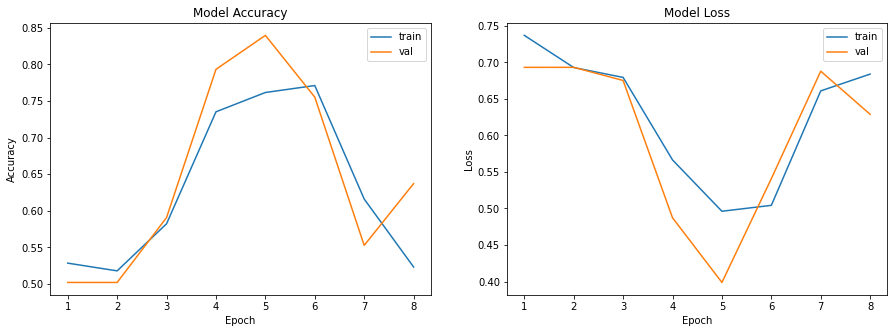

In [35]:
plot_model_history(da_cnn)

In [36]:
model_dacnn=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_dacnn.h5")

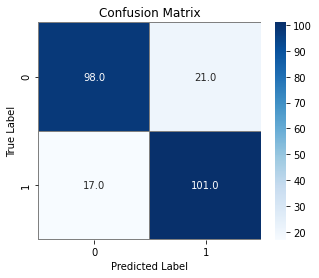

In [37]:
y_pred_dacnn =  model_dacnn.predict_classes(x_test)

plot_confusion_matrix(y_pred_dacnn)

# **VGG-19**

In [41]:
from keras.layers import Input,Lambda,Dense,Flatten ## This library used to solve will generate the output layers
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input ## Preprocessing the input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator ## this will actually help you to perform the image augmentation
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers

pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers:
    layer.trainable = False

    
vggmodel = Sequential()
# building the model 
vggmodel.add(pre_trained_model)
vggmodel.add(Flatten())
vggmodel.add(Dense(128,activation="relu"))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(1,activation="sigmoid"))

vggmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

vggmodel.summary()

80142336/80134624 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 23,235,905
Trainable params: 3,211,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [43]:
# simple early stopping
es_vgg = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc_vgg = ModelCheckpoint('/content/drive/My Drive/Pothole Detection/best_model_vgg.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
v_history = vggmodel.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30, callbacks=[es_vgg, mc_vgg])

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.8133
Epoch 00001: val_accuracy improved from -inf to 0.94515, saving model to /content/drive/My Drive/Pothole Detection/best_model_vgg.h5
30/30 [==============================] - 4s 130ms/step - loss: 0.6058 - accuracy: 0.8133 - val_loss: 0.1394 - val_accuracy: 0.9451
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9568
Epoch 00002: val_accuracy improved from 0.94515 to 0.95359, saving model to /content/drive/My Drive/Pothole Detection/best_model_vgg.h5
30/30 [==============================] - 3s 109ms/step - loss: 0.1240 - accuracy: 0.9568 - val_loss: 0.1257 - val_accuracy: 0.9536
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9736
Epoch 00003: val_accuracy improved from 0.95359 to 0.95781, saving model to /content/drive/My Drive/Pothole Detection/best_model_vgg.h5
30/30 [==============================] - 3s 108ms/s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


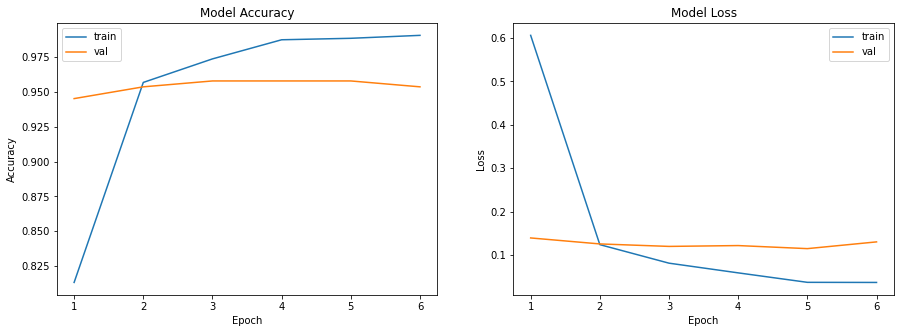

In [44]:
plot_model_history(v_history)

In [45]:
model_vgg=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_model_vgg.h5")

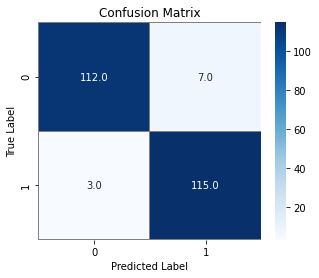

In [47]:
y_pred_vgg =  model_vgg.predict_classes(x_test)

plot_confusion_matrix(y_pred_vgg)

VGG 19 with Data augmentation

In [48]:


from keras.layers import Input,Lambda,Dense,Flatten ## This library used to solve will generate the output layers
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input ## Preprocessing the input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator ## this will actually help you to perform the image augmentation
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers

pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers:
    layer.trainable = False


# horizontal flips and rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


vggdamodel = Sequential()
vggdamodel.add(data_augmentation)
# building the model 
vggdamodel.add(pre_trained_model)
vggdamodel.add(Flatten())
vggdamodel.add(Dense(128,activation="relu"))
vggdamodel.add(Dropout(0.3))
vggdamodel.add(Dense(1,activation="sigmoid"))

vggdamodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [50]:
# simple early stopping
es_davgg = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc_davgg = ModelCheckpoint('/content/drive/My Drive/Pothole Detection/best_damodel_vgg.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
dav_history = vggdamodel.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30, callbacks=[es_davgg, mc_davgg])

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.7173
Epoch 00001: val_accuracy improved from -inf to 0.89873, saving model to /content/drive/My Drive/Pothole Detection/best_damodel_vgg.h5
30/30 [==============================] - 6s 192ms/step - loss: 0.9442 - accuracy: 0.7173 - val_loss: 0.3121 - val_accuracy: 0.8987
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8418
Epoch 00002: val_accuracy improved from 0.89873 to 0.91983, saving model to /content/drive/My Drive/Pothole Detection/best_damodel_vgg.h5
30/30 [==============================] - 3s 112ms/step - loss: 0.3390 - accuracy: 0.8418 - val_loss: 0.2479 - val_accuracy: 0.9198
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8871
Epoch 00003: val_accuracy did not improve from 0.91983
30/30 [==============================] - 3s 97ms/step - loss: 0.2764 - accuracy: 0.8871 - val_loss: 0.2480 - val_accuracy: 0.907

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


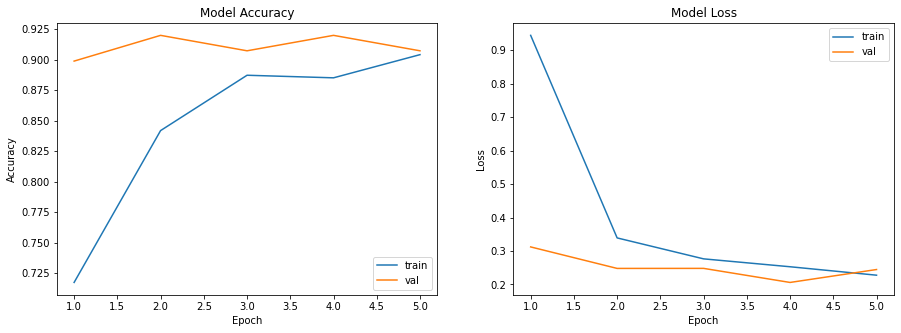

In [51]:
plot_model_history(dav_history)

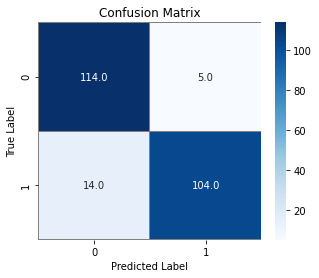

In [52]:
model_vgg=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_damodel_vgg.h5")

y_pred_vgg =  model_vgg.predict_classes(x_test)

plot_confusion_matrix(y_pred_vgg)

## **Fine Tuning**

In [54]:
from keras.layers import Input,Lambda,Dense,Flatten ## This library used to solve will generate the output layers
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input ## Preprocessing the input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator ## this will actually help you to perform the image augmentation
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers

pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:21]:
    layer.trainable = False

for layer in pre_trained_model.layers[21:]:
    layer.trainable = True
    
ftvggmodel = Sequential()
# building the model 
ftvggmodel.add(pre_trained_model)
ftvggmodel.add(Flatten())
ftvggmodel.add(Dense(128,activation="relu"))
ftvggmodel.add(Dropout(0.3))
ftvggmodel.add(Dense(1,activation="sigmoid"))

ftvggmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

ftvggmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 23,235,905
Trainable params: 3,211,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [55]:
# simple early stopping
es_vggft = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc_vggft = ModelCheckpoint('/content/drive/My Drive/Pothole Detection/best_model_vggft.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
vft_history = ftvggmodel.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30, callbacks=[es_vggft, mc_vggft])

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.7384
Epoch 00001: val_accuracy improved from -inf to 0.93671, saving model to /content/drive/My Drive/Pothole Detection/best_model_vggft.h5
30/30 [==============================] - 3s 114ms/step - loss: 0.8910 - accuracy: 0.7384 - val_loss: 0.1880 - val_accuracy: 0.9367
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9114
Epoch 00002: val_accuracy improved from 0.93671 to 0.94515, saving model to /content/drive/My Drive/Pothole Detection/best_model_vggft.h5
30/30 [==============================] - 3s 107ms/step - loss: 0.2403 - accuracy: 0.9114 - val_loss: 0.1743 - val_accuracy: 0.9451
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9494
Epoch 00003: val_accuracy did not improve from 0.94515
30/30 [==============================] - 3s 95ms/step - loss: 0.2006 - accuracy: 0.9494 - val_loss: 0.1696 - val_accuracy: 0.945

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


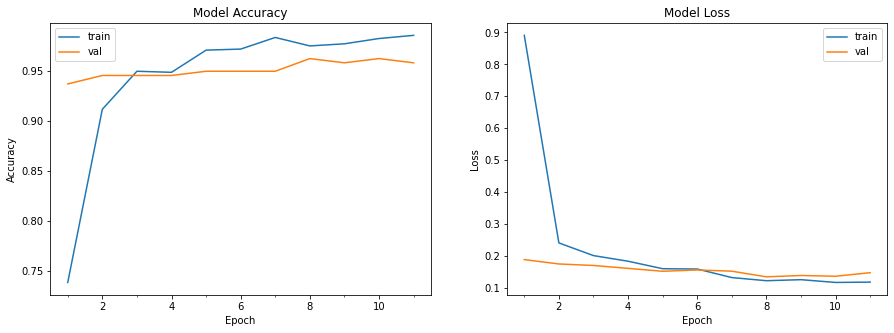

In [56]:
plot_model_history(vft_history)

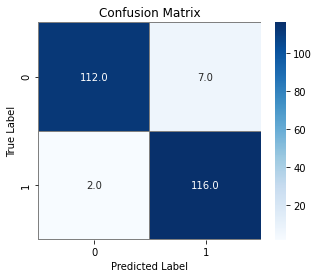

In [57]:
model_ftvgg=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_model_vggft.h5")

y_pred_ftvgg =  model_ftvgg.predict_classes(x_test)

plot_confusion_matrix(y_pred_ftvgg)

## **VGG Fine Tuning with Data Augmentation**

In [59]:
from keras.layers import Input,Lambda,Dense,Flatten ## This library used to solve will generate the output layers
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input ## Preprocessing the input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator ## this will actually help you to perform the image augmentation
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers

pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:21]:
    layer.trainable = False

for layer in pre_trained_model.layers[21:]:
    layer.trainable = True

# horizontal flips and rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

    
ftdamodel = Sequential()
ftdamodel.add(data_augmentation)
# building the model 
ftdamodel.add(pre_trained_model)
ftdamodel.add(Flatten())
ftdamodel.add(Dense(512,activation="relu"))
ftdamodel.add(Dropout(0.3))
ftdamodel.add(Dense(1,activation="sigmoid"))

ftdamodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [60]:
# simple early stopping
es_ft = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
mc_ft = ModelCheckpoint('/content/drive/My Drive/Pothole Detection/best_model_ftda.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
tf_history = ftdamodel.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=30, callbacks=[es_ft, mc_ft])

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.3729 - accuracy: 0.7426
Epoch 00001: val_accuracy improved from -inf to 0.90717, saving model to /content/drive/My Drive/Pothole Detection/best_model_ftda.h5
30/30 [==============================] - 4s 134ms/step - loss: 1.3729 - accuracy: 0.7426 - val_loss: 0.2407 - val_accuracy: 0.9072
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9188
Epoch 00002: val_accuracy improved from 0.90717 to 0.91983, saving model to /content/drive/My Drive/Pothole Detection/best_model_ftda.h5
30/30 [==============================] - 4s 132ms/step - loss: 0.2057 - accuracy: 0.9188 - val_loss: 0.2121 - val_accuracy: 0.9198
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9251
Epoch 00003: val_accuracy improved from 0.91983 to 0.94515, saving model to /content/drive/My Drive/Pothole Detection/best_model_ftda.h5
30/30 [==============================] - 4s 129m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


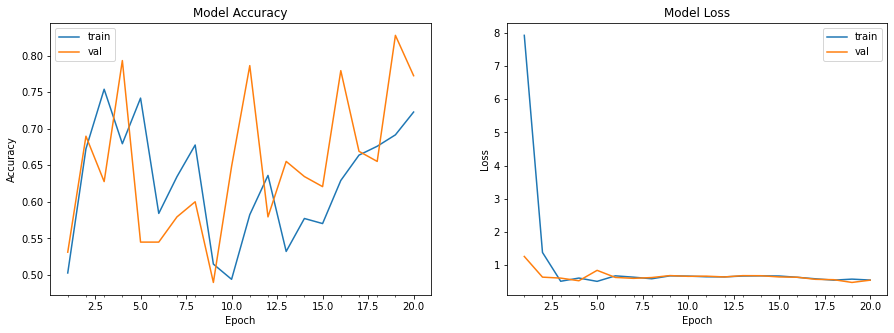

In [ ]:
plot_model_history(tf_history)

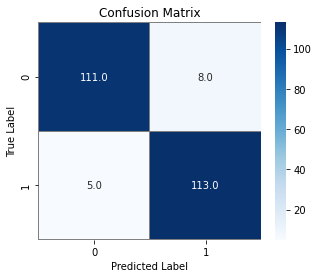

In [61]:
model_ft=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_model_ftda.h5")

y_pred_ft =  model_ft.predict_classes(x_test)

plot_confusion_matrix(y_pred_ft)

## **Checking prediction of some images**

#### The best model we got is the VGG 19 with Fine Tuning and without data augmentation. Let us use the model to predict on some unseen images

In [82]:
def model_predict(img_path, model):
    labels_dict = {0:'Plain', 1:'Pothole'}
    image_size = 224
    img_array = cv2.imread(img_path,cv2.IMREAD_COLOR)
    
    new_array = cv2.resize(img_array,(image_size,image_size))
    x= new_array.reshape(1,image_size,image_size,3)/255
    plt.imshow(img_array)
    #x = np.expand_dims(x, axis=0)
   

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
   # x = preprocess_input(x)
    y_pred = np.round(model.predict(x))
    if y_pred[0][0] == 1:
        print("No potholes detected")
    else:
        print("Potholes detected")


No potholes detected


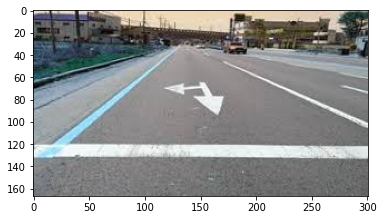

In [83]:
model_ftvgg=tf.keras.models.load_model("/content/drive/My Drive/Pothole Detection/best_model_vggft.h5")

model_predict('/content/drive/My Drive/Pothole Detection/uploads/4.jpg',model_ftvgg)

Potholes detected


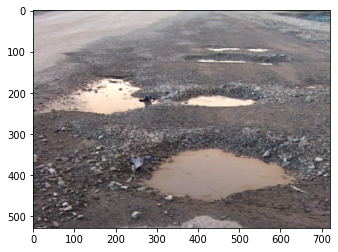

In [84]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/11.jpg',model_ftvgg)

Potholes detected


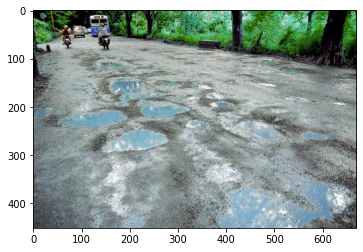

In [85]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/12.jpg',model_ftvgg)

No potholes detected


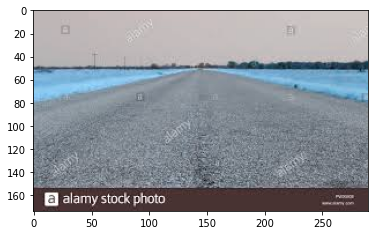

In [86]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/2.jpg',model_ftvgg)

No potholes detected


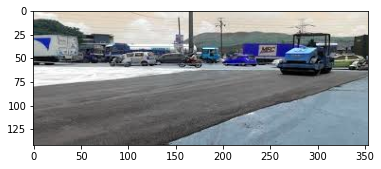

In [87]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/5.jpg',model_ftvgg)

Potholes detected


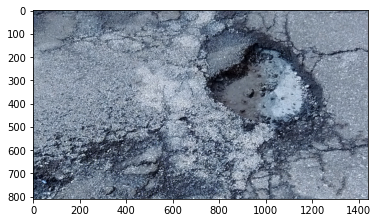

In [88]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/18.jpg',model_ftvgg)

Potholes detected


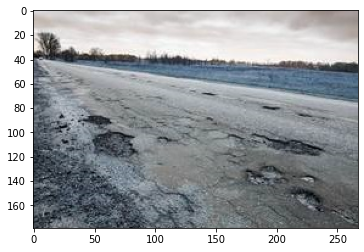

In [89]:
model_predict('/content/drive/My Drive/Pothole Detection/uploads/14.jpg',model_ftvgg)

## **Deployment**

In [ ]:
from tkinter import *
from tkinter import ttk # For Tree table
import tkinter.messagebox as MessageBox
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from tkinter import Entry , messagebox , Text , END , Tk , Button , Label , StringVar , PhotoImage, Radiobutton
import tkinter.font as tkFont

def select():
    messagebox.showinfo('Select' , 'Select the Image to be Checked' )
    file = askopenfile(title='Please select one (any) frame from your set of images.',
                           filetypes=[('Image Files', ['.jpeg', '.jpg', '.png', '.gif',
                                                       '.tiff', '.tif', '.bmp'])])
    path_holder.insert(0 ,file.name)
    load = Image.open(f'{file.name}')
    load = load.resize((250 , 250))
    render = ImageTk.PhotoImage(load)
    picture_display.config(image=render)
    picture_display.image = render
    picture_display.pack()

            
def detect():

    model = tf.keras.models.load_model('/content/drive/My Drive/Pothole Detection/best_model_vggft.h5')
    
    image_size = 224
    img_array = cv2.imread(path_variable.get(),cv2.IMREAD_COLOR)
    
    new_array = cv2.resize(img_array,(image_size,image_size))
    x= new_array.reshape(1,image_size,image_size,3)/255

    y_pred = np.round(model.predict(x))
    if y_pred[0][0] == 1:
        print("No potholes detected")
    else:
        print("Potholes detected")



def main_w():    
    main_window = Tk()
    main_window.geometry('1000x850')
    main_window.title('Pothole Detection')
    main_window.configure(bg='white')
    fontstyle = tkFont.Font(size=20)
    label_main=Label(main_window,width=1000,text='Pothole Detection',bg='deepskyblue3',fg='white',font=fontstyle,padx=300,pady=50).pack()    

    select_image_button = Button(main_window , text = 'Select Image' , command = select,bg='white',fg='black',pady=10).pack()
    detect_image_button = Button(main_window , text = 'Detect' , command = detect).pack()
    picture_display = Label(main_window , text = 'Image' , font = fontstyle).pack()

    path_variable = StringVar()
    path = Entry(main_window , textvariable = path_variable , font = fontStyle , width = 25)
        

    main_window.mainloop()
                                
main_w()